# YOUTUBE VIEWS PREDICTION

## BUSINESS UNDERSTANDING

In this project we want to see the factors that influence the popularity of a Youtube video or rather the factors that make one Youtube video have more views than another.

## DATA UNDERSTANDING

Data used was gotten from `YouTube` through the `Youtube API` meaning its real time data from channels on Youtube.

Libraries to be used.

In [2]:
# For analysis and data manipulation
import pandas as pd
import numpy as np

# For visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# For getting api key
import os
from dotenv import load_dotenv
from googleapiclient.discovery import build

# Splitting data, building model and testing it
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


Loading `env` file to obtain API key for security purposes when pushing it to Github.

In [3]:
path_to_env = '.env'
load_dotenv(path_to_env)

True

Getting all the info of the videos of various channels on YouTube using their `channel id` and the `api key` gotten from YouTube API using a function called `get_channel_video_info`

In [65]:
def get_channel_video_info(api_key, channel_ids):
    """
    --------------------------------------------------------------------------------------------------
    Gets the title, number of likes, comment_count, number of views, and the duration of each video in a channel
    given the API Key from YouTube's API and the channel_ids of the channels.
    --------------------------------------------------------------------------------------------------
    Input : API Key, List of Channel IDs
    Returns : Video information in the form of a dictionary
    """
    youtube = build('youtube', 'v3', developerKey=api_key)

    video_info_dict = {}

    for channel_id in channel_ids:
        # Getting the playlist ID of the uploaded videos for the channel
        channels_response = youtube.channels().list(
            part='contentDetails',
            id=channel_id
        ).execute()
        playlist_id = channels_response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

        # Get the videos from the playlist, including video details
        videos = []
        next_page_token = None

        while True:
            playlist_response = youtube.playlistItems().list(
                part='snippet',
                playlistId=playlist_id,
                maxResults=50,  # You can adjust this based on your needs
                pageToken=next_page_token
            ).execute()

            video_ids = [item['snippet']['resourceId']['videoId'] for item in playlist_response['items']]

            videos_response = youtube.videos().list(
                part='snippet,contentDetails,statistics',
                id=','.join(video_ids)
            ).execute()

            videos.extend(videos_response['items'])
            next_page_token = playlist_response.get('nextPageToken')

            if not next_page_token:
                break

        for video in videos:
            title = video['snippet'].get('title')
            views = video['statistics'].get('viewCount')
            length = video['contentDetails'].get('duration')
            likes = video['statistics'].get('likeCount')
            tags = video['snippet'].get('tags')
            comment_count = video['statistics'].get('commentCount')

            video_info = {
                'views': views,
                'length': length,
                'likes': likes,
                'tags': tags,
                'commentCount': comment_count
            }

            video_info_dict[title] = video_info

    return video_info_dict

# Testing function
api_key = os.getenv("API_KEY")
channel_ids = ['UCC15bXbPxX_Q6pqKxko-ZkA', 'UCXDpWv7uC_rONzwOSC1KRZQ', 'UCNvzD7Z-g64bPXxGzaQaa4g', 'UCFY0YHhxiIQWYYsLgeUBcbg', 'UC2UXDak6o7rBm23k3Vv5dww', 'UC9Kq-yEt1iYsbUzNOoIRK0g', 'UCOpcACMWblDls9Z6GERVi1A', 'UCsXVk37bltHxD1rDPwtNM8Q', 'UCftwRNsjfRo08xYE31tkiyw', 'UCBJycsmduvYEL83R_U4JriQ']
video_info_dict = get_channel_video_info(api_key, channel_ids)

# Print or use video_info_dict as needed
print(video_info_dict)

{'How Chelsea Are Using AI To Scout Players': {'views': '6554', 'length': 'PT5M16S', 'likes': '232', 'tags': ['FourFourTwo', 'Football', 'Soccer', 'Premier League'], 'commentCount': '45'}, 'What No European Football Means For Manchester United': {'views': '8737', 'length': 'PT9M33S', 'likes': '412', 'tags': ['FourFourTwo', 'Football', 'Soccer', 'Premier League'], 'commentCount': '44'}, 'Everton Getting ANOTHER Points Deduction Explained': {'views': '35659', 'length': 'PT8M49S', 'likes': '1140', 'tags': ['FourFourTwo', 'Football', 'Soccer', 'Premier League', 'Everton', 'Everton highlights', 'Everton goals', 'Everton takeover', 'Everton administration', 'Everton points deduction'], 'commentCount': '215'}, "Why Rasmus Hojlund Isn't Scoring Goals For Man United": {'views': '60902', 'length': 'PT11M30S', 'likes': '1834', 'tags': ['FourFourTwo', 'Football', 'Soccer', 'Premier League'], 'commentCount': '358'}, 'Why Aston Villa Can Genuinely Win The Premier League': {'views': '18323', 'length'

**Function works as expected and returns a dictionary called `video_info_dict` with all the relevant info about the channels in the list.**

Creating dataframe from created dictionary

In [63]:
# Creating dataframe from values of dataframe
video_info_list = list(video_info_dict.values())
video_df = pd.DataFrame(video_info_list)

# Adding new column for the title of the videos
video_df['title'] = list(video_info_dict.keys())
video_df['title length'] = [len(x) for x in video_df['title']]

# Changing order of columns
new_order = ['title', 'title length', 'length', 'likes', 'commentCount', 'views']
video_df = video_df.reindex(columns=new_order)

# Results
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12531 entries, 0 to 12530
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         12531 non-null  object 
 1   title length  12531 non-null  int64  
 2   length        12531 non-null  object 
 3   likes         12514 non-null  object 
 4   commentCount  0 non-null      float64
 5   views         12523 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 587.5+ KB


## DATA PREPARATION

Changing duration time to seconds

In [40]:
# Changing to seconds
video_df['length'] = pd.to_timedelta(video_df['length']).dt.total_seconds()

# Results
video_df.head()

title  title length  length  \
0          How Chelsea Are Using AI To Scout Players            41   316.0   
1  What No European Football Means For Manchester...            53   573.0   
2  Everton Getting ANOTHER Points Deduction Expla...            50   529.0   
3  Why Rasmus Hojlund Isn't Scoring Goals For Man...            53   690.0   
4  Why Aston Villa Can Genuinely Win The Premier ...            52   754.0   

  likes commentCount  views  
0   232           45   6507  
1   412           44   8719  
2  1138          214  35636  
3  1829          358  60853  
4   760          144  18303

Changing `length` to `Video Length in Seconds`

In [41]:
video_df.rename(columns={'length':'Video Length in Seconds'}, inplace=True)


Dealing with null values.

In [42]:
video_df.dropna(axis=0, inplace=True)

video_df

title  title length  \
0              How Chelsea Are Using AI To Scout Players            41   
1      What No European Football Means For Manchester...            53   
2      Everton Getting ANOTHER Points Deduction Expla...            50   
3      Why Rasmus Hojlund Isn't Scoring Goals For Man...            53   
4      Why Aston Villa Can Genuinely Win The Premier ...            52   
...                                                  ...           ...   
12526                    Fraps HD Test in 1080p (18 WOS)            31   
12527      HP Pavilion dv7t Media Center Remote Overview            45   
12528                        High fps LG Voyager footage            27   
12529              14 Year knock-down shot (11 Handicap)            37   
12530                    13-Year-Old Golf Swing Analysis            31   

       Video Length in Seconds   likes commentCount    views  
0                        316.0     232           45     6507  
1                        573.0     412           44     8719  
2                        529.0    1138          214    35636  
3                        690.0    1829          358    60853  
4                        754.0     760          144    18303  
...                        ...     ...          ...      ...  
12526                     91.0    1718          239   142619  
12527                    171.0  238367        36614  4815166  
12528                     31.0    2890          733   198783  
12529                     41.0    2415          371   189244  
12530                     32.0   19412         3768   873274  

[12183 rows x 6 columns]

In [43]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12183 entries, 0 to 12530
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    12183 non-null  object 
 1   title length             12183 non-null  int64  
 2   Video Length in Seconds  12183 non-null  float64
 3   likes                    12183 non-null  object 
 4   commentCount             12183 non-null  object 
 5   views                    12183 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 666.3+ KB


Building trial model

In [44]:
# Feature and target variables
X = video_df[['title length', 'Video Length in Seconds', 'likes', 'commentCount']]
X['likes'] = [int(x) for x in X['likes']]
y = video_df['views']

# Splitting to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instatiating and training model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prediction and metrics
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('The R2 score of the model is', r2)
print('The mae of the model is', mae)
print('The mse of the model is', mse)
print('The rmse of the model is', rmse)

The R2 score of the model is 0.7649771023647343
The mae of the model is 567607.7235567913
The mse of the model is 3148045479195.0347
The rmse of the model is 1774273.2256321276


C:\Users\USER\AppData\Local\Temp\ipykernel_22784\3654293915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['likes'] = [int(x) for x in X['likes']]


Model is performing very badly possibly suggesting the relationship is non-linear.

In [45]:
video_df['commentCount'] = video_df['commentCount'].apply(lambda x: int(x))
video_df['views'] = video_df['views'].apply(lambda x: int(x))

Using scatter plot to see relationship between independent and dependent features.

c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


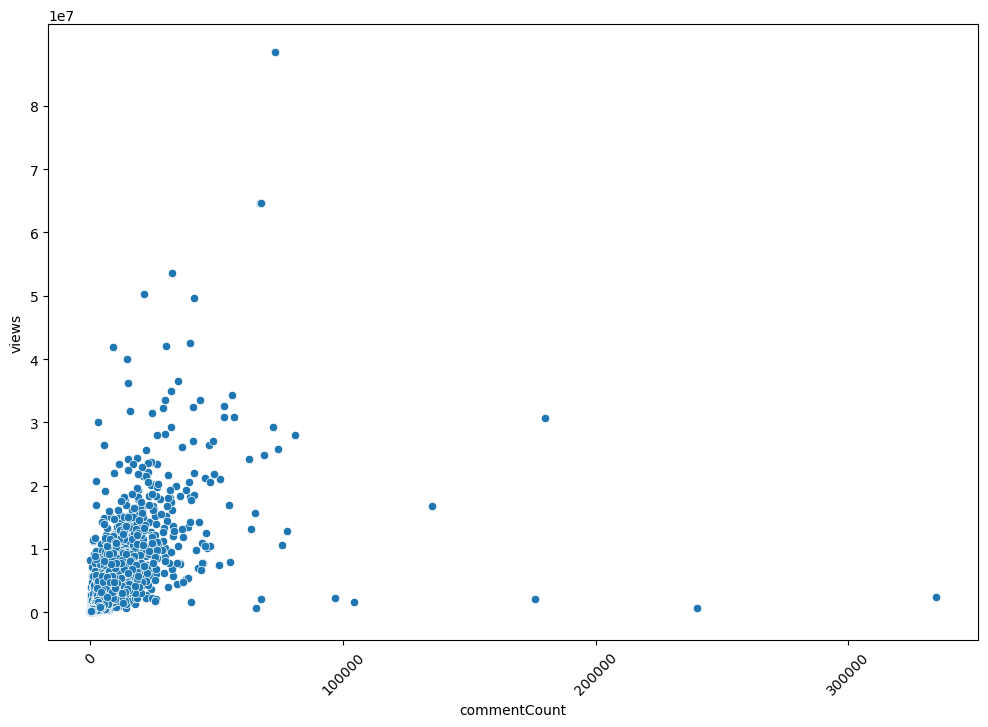

In [51]:
# Figure size
plt.figure(figsize=(12, 8))  # Set the size of the figure

# Making values of x-axis appear at 45 degree angle for aesthetic purposes.
plt.xticks(rotation=45)

# Adjusting the tick intervals on the x-axis and y-axis
plt.xticks(range(0, max(video_df['commentCount']), 100000))
plt.yticks(range(0, max(video_df['views']), 10000000))

sns.scatterplot(video_df, x=video_df['commentCount'], y=video_df['views']);  # Plot the scatter plot

plt.show()

There is no linear correlation between `commentCount` and `views` which are the dependent and independent variables respectively.

In [52]:
new_df = video_df.drop('title', axis=1)
new_df.corr()

title length  Video Length in Seconds     likes  \
title length                 1.000000                 0.053423 -0.064261   
Video Length in Seconds      0.053423                 1.000000  0.009294   
likes                       -0.064261                 0.009294  1.000000   
commentCount                -0.115916                 0.030869  0.651732   
views                       -0.067343                 0.007740  0.871305   

                         commentCount     views  
title length                -0.115916 -0.067343  
Video Length in Seconds      0.030869  0.007740  
likes                        0.651732  0.871305  
commentCount                 1.000000  0.610745  
views                        0.610745  1.000000

Finding correlation between features and target shows likes has the most correlation which makes sense since the more the no of likes its likely to receive or although its also possible that everyone who sees the video dislikes it.

In [53]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
y_train = y_train.apply(lambda x: int(x))
y_train_scaled = pd.Series([((x - y_train.mean()) / y_train.std()) for x in y_train])


In [ ]:
y_train_scaled

In [54]:
plt.figure(figsize=(12, 8))
plt.title('Comment count vs no of views')
plt.xlabel('Comment count')
plt.ylabel('No of views')
plt.scatter(x=X_train_scaled['commentCount'], y=y_train_scaled);

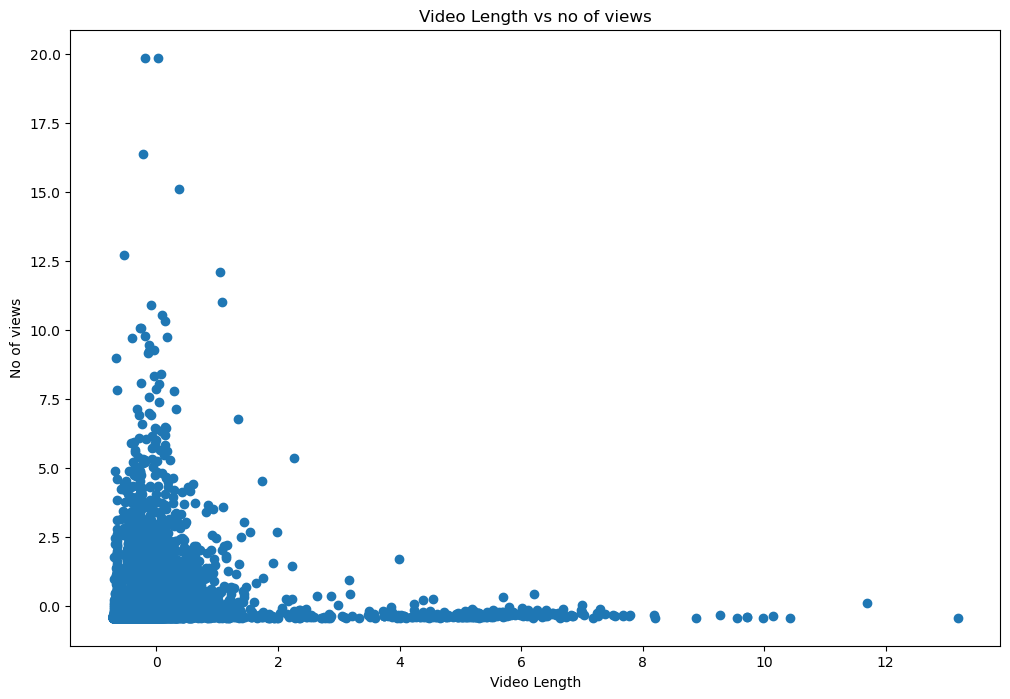

In [55]:
plt.figure(figsize=(12, 8))
plt.title('Video Length vs no of views')
plt.xlabel('Video Length')
plt.ylabel('No of views')
plt.scatter(x=X_train_scaled['Video Length in Seconds'], y=y_train_scaled);

**Even after scaling the values to reduce the gap between values the relationship between the independent and dependent variables is still non-linear.**

Building model on scaled data.

In [56]:
# Instatiate model
lr_scaled = LinearRegression()

# Train on scaled data
lr_scaled.fit(X_train_scaled, y_train)

# Make predictions
scaled_predictions = lr_scaled.predict(X_test_scaled)

# Metrics
r2_scaled = r2_score(y_test, scaled_predictions)
mse_scaled = mean_squared_error(y_test, scaled_predictions, squared=True)

# Results
print('The r2 score of the scaled data is', r2_scaled)
print('The mse of the scaled data is', mse_scaled)

The r2 score of the scaled data is 0.7649771023647342
The mse of the scaled data is 3148045479195.035


Using polynomial degrees to try and deal with the non-linear relationship between variables.

In [57]:
# Instantiate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True)

# Transform datasets
X_train_poly_array = poly.fit_transform(X_train_scaled)
X_test_poly_array = poly.transform(X_test_scaled)

# Generate column names
poly_column_names = [f"X{i}" for i in range(X_train_poly_array.shape[1])]

# Create DataFrame for polynomial features
X_train_poly = pd.DataFrame(X_train_poly_array, columns=poly_column_names)
X_test_poly = pd.DataFrame(X_test_poly_array, columns=poly_column_names)

# Instantiate model
lr_poly = LinearRegression(fit_intercept=False)

# Fit and train data
lr_poly.fit(X_train_poly, y_train)

# Predictions
lr_poly_predictions = lr_poly.predict(X_test_poly)

# Metrics
r2 = r2_score(y_test, lr_poly_predictions)
mse = mean_squared_error(y_test, lr_poly_predictions)
print("R-squared:", r2)
print("MSE", mse)

R-squared: 0.7645512799546748
MSE 3153749214134.9717


In [ ]:
X_train_poly

In [58]:
# Function for checking outliers in a dataframe removing them and creating a new dataframe without outliers
def outliers(df):

    # Dictionary for placing no. of outliers and the column name.
    outliers_dict = {}
    standardized_dict = {}

    # For loop for checking outliers in every column in the dataframe.
    for column in df.columns:
        # Lower quantile
        Q1 = df[column].quantile(0.25)

        # Upper Quantile
        Q3 = df[column].quantile(0.75)

        # Finding IQR
        IQR = Q3 - Q1

        # Defining lower and upper bound
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Finding outliers
        outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_dict[column] = 'The number of outliers is', len(outliers)

        # Data without outliers
        standardized_numvotes = df[column][(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
        # Putting standardized values in a dict
        standardized_dict[column] = standardized_numvotes

    
    standardized_df = pd.DataFrame(standardized_dict)  

    # Results
    return standardized_df

In [59]:
# Converting likes to int format
new_df['likes'] = [int(x) for x in new_df['likes']]

# Removing outliers and null values
non_outlier_df = outliers(new_df).dropna(axis=0)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate model
new_lr = LinearRegression()

# Fitting and training model
new_lr.fit(X_train, y_train)

# Predictions
new_predictions = new_lr.predict(X_test)

# Metrics
new_r2 = r2_score(y_test, new_predictions)
new_mse = mean_squared_error(y_test, new_predictions, squared=True)

# Results
new_mse

3148045479195.0347

In [60]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

rfr_predictions = rfr.predict(X_test)

rfr_r2 = r2_score(y_test, rfr_predictions)
rfr_rmse = mean_absolute_error(y_test, rfr_predictions)

print(rfr_r2)
print(rfr_rmse)

0.7765240107642102
435230.609744563


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

# Define the RandomForestRegressor model
rfr = RandomForestRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(rfr, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model and its predictions
best_model = grid_search.best_estimator_
rfr_predictions = best_model.predict(X_test)

# Calculate evaluation metrics
rfr_r2 = r2_score(y_test, rfr_predictions)
rfr_rmse = mean_absolute_error(y_test, rfr_predictions)

# Print the evaluation metrics
print("R-squared:", rfr_r2)
print("RMSE:", rfr_rmse)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

In [ ]:
best_rfr = RandomForestRegressor(max_depth=15, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=500)

best_rfr.fit(X_train, y_train)

best_rfr_predictions = best_rfr.predict(X_test)

best_rfr_r2 = r2_score(y_test, best_rfr_predictions)
best_rfr_mae = mean_absolute_error(y_test, best_rfr_predictions)

print(best_rfr_r2)
print(best_rfr_mae)

0.821290471104981
30070.25709322628


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gr_model = GradientBoostingRegressor()

gr_model.fit(X_train, y_train)

gr_predictions = gr_model.predict(X_test)

gr_r2 = r2_score(y_test, gr_predictions)
gr_mae = mean_absolute_error(y_test, gr_predictions)

print(gr_r2)
print(gr_mae)

0.7640033483139229
207769.08263301893


In [33]:
from sklearn.ensemble import AdaBoostRegressor

ab_model = GradientBoostingRegressor()

ab_model.fit(X_train, y_train)

ab_predictions = ab_model.predict(X_test)

ab_r2 = r2_score(y_test, ab_predictions)
ab_mae = mean_absolute_error(y_test, ab_predictions)

print(ab_r2)
print(ab_mae)

0.7644165752545268
207740.70420320323


In [34]:
import xgboost as xg

xgb_r = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 42)

xgb_r.fit(X_train, y_train)

xgb_predictions = xgb_r.predict(X_test)

xgb_r2 = r2_score(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print(xgb_r2)
print(xgb_mae)

c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\xgboost\data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\xgboost\data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_categorical_dtype(dtype) and enable_categorical)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:commentCount: object

In [123]:
channel_id = 'UCMiJRAwDNSNzuYeN2uWa0pA'

boss_dict = get_channel_video_info(api_key, channel_id)

In [142]:
boss_df = pd.DataFrame(list(boss_dict.values()))
boss_df['title'] = boss_dict.keys()

# Adding new column for the title of the videos
boss_df['title'] = boss_dict.keys()
boss_df['title length'] = [len(x) for x in boss_df['title']]

# Changing to seconds
boss_df['length'] = pd.to_timedelta(boss_df['length']).dt.total_seconds()

# # Changing order of columns
# new_order = ['title', 'title length', 'length', 'likes', 'commentCount', 'views']
# boss_df = video_df.reindex(columns=new_order)

# Results
boss_df.head()

views  length   likes                                               tags  \
0   815236    41.0   86033                                               None   
1  3301792  2410.0  133742                 [japan, tech, technology, gadgets]   
2   556367    54.0   45708                 [shorts, tech, gadgets, earphones]   
3  1150013    60.0  102939            [tech, shorts, gaming, nintendo, retro]   
4  3387551  1189.0  166995  [tech, phones, smartphones, best, top, awards,...   

  commentCount                                title  title length  
0          437               This Ruler does WHAT!?            22  
1         5235  I bought the CRAZIEST tech in Japan            35  
2          525           Best Value Earphones EVER!            26  
3          967     I bought EVERY Nintendo Console!            32  
4         8394        The BEST Smartphones of 2023!            29

In [143]:
boss_df.rename(columns={'length':'Video Length in Seconds'}, inplace=True)

In [144]:
boss_df.dropna(axis=0, inplace=True)

In [145]:
# Feature and target variables
X = boss_df[['title length', 'Video Length in Seconds', 'likes', 'commentCount']]
X['likes'] = [int(x) for x in X['likes']]
y = boss_df['views']

# Splitting to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instatiating and training model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prediction and metrics
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('The R2 score of the model is', r2)
print('The mae of the model is', mae)
print('The mse of the model is', mse)
print('The rmse of the model is', rmse)

The R2 score of the model is 0.89587447864536
The mae of the model is 782590.604758727
The mse of the model is 2483349305574.721
The rmse of the model is 1575864.6215886443


C:\Users\USER\AppData\Local\Temp\ipykernel_21112\875507185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['likes'] = [int(x) for x in X['likes']]


In [146]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

rfr_predictions = rfr.predict(X_test)

rfr_r2 = r2_score(y_test, rfr_predictions)
rfr_rmse = mean_absolute_error(y_test, rfr_predictions)

print(rfr_r2)
print(rfr_rmse)

0.9153864006978597
595972.2981790123


In [147]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

# Define the RandomForestRegressor model
rfr = RandomForestRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(rfr, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model and its predictions
best_model = grid_search.best_estimator_
rfr_predictions = best_model.predict(X_test)

# Calculate evaluation metrics
rfr_r2 = r2_score(y_test, rfr_predictions)
rfr_rmse = mean_absolute_error(y_test, rfr_predictions)

# Print the evaluation metrics
print("R-squared:", rfr_r2)
print("RMSE:", rfr_rmse)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1125 fits failed out of a total of 3375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1125 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\USER\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_co

R-squared: 0.9281275364800184
RMSE: 569092.7687282669
Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [156]:
combined_df = pd.concat([video_df, boss_df], axis=0)


In [158]:
combined_df.dropna(axis=0, inplace=True)

In [159]:
combined_df

title  title length  \
1                  I bought the CRAZIEST tech in Japan            35   
2                           Best Value Earphones EVER!            26   
3                     I bought EVERY Nintendo Console!            32   
4                        The BEST Smartphones of 2023!            29   
5                                 Shoes of the Future!            20   
...                                                ...           ...   
1630      Acer Iconia a500 gaming and performance test            44   
1631   Acer Iconia a500 unboxing and first impressions            47   
1632      How to install a custom rom onto a ZTE Blade            44   
1633  Olympus SZ-10 Camera/ Hama Star 61 Tripod Review            48   
1634                    How to optimize your ZTE Blade            30   

      Video Length in Seconds   likes commentCount    views  \
1                      2410.0  133742         5235  3301792   
2                        54.0   45708          525   556367   
3                        60.0  102939          967  1150013   
4                      1189.0  166995         8394  3387551   
5                        45.0  135759          512  1654108   
...                       ...     ...          ...      ...   
1630                    502.0    1118          169    45889   
1631                    441.0    2036          343    53699   
1632                    653.0    1097          247    61860   
1633                    206.0    1883          256    86776   
1634                    494.0   25196         6914   683382   

                                                   tags  
1                    [japan, tech, technology, gadgets]  
2                    [shorts, tech, gadgets, earphones]  
3               [tech, shorts, gaming, nintendo, retro]  
4     [tech, phones, smartphones, best, top, awards,...  
5              [tech, gadgets, shoes, nike, futuristic]  
...                                                 ...  
1630  [Acer, Iconia, A500, games, performance gamepl...  
1631  [Acer Iconia Tab A500, acer, iconia, nvidia, t...  
1632  [Orange, San, Francisco, ZTE, Blade, Speed, Pe...  
1633  [camera, digital, Hama, star, 61, olympus, SZ1...  
1634  [Orange, San Francisco, ZTE, Blade, Speed, Per...  

[1618 rows x 7 columns]

In [160]:
# Feature and target variables
X = combined_df[['title length', 'Video Length in Seconds', 'likes', 'commentCount']]
X['likes'] = [int(x) for x in X['likes']]
y = combined_df['views']

# Splitting to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instatiating and training model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prediction and metrics
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('The R2 score of the model is', r2)
print('The mae of the model is', mae)
print('The mse of the model is', mse)
print('The rmse of the model is', rmse)

The R2 score of the model is 0.89587447864536
The mae of the model is 782590.604758727
The mse of the model is 2483349305574.721
The rmse of the model is 1575864.6215886443


C:\Users\USER\AppData\Local\Temp\ipykernel_21112\1201870552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['likes'] = [int(x) for x in X['likes']]


Neural network model

In [162]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1618 entries, 1 to 1634
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    1618 non-null   object 
 1   title length             1618 non-null   int64  
 2   Video Length in Seconds  1618 non-null   float64
 3   likes                    1618 non-null   object 
 4   commentCount             1618 non-null   object 
 5   views                    1618 non-null   object 
 6   tags                     1618 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 101.1+ KB


In [164]:
combined_df.columns

Index(['title', 'title length', 'Video Length in Seconds', 'likes',
       'commentCount', 'views', 'tags'],
      dtype='object')

In [166]:
from keras.models import Sequential
from keras.layers import Dense

# Feature and target variables
X = combined_df[['title length', 'Video Length in Seconds', 'likes', 'commentCount']].copy()
X['likes'] = [int(x) for x in X['likes']]
X['commentCount'] = [int(x) for x in X['commentCount']]
y = combined_df['views'].apply(lambda x: int(x))

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=1, verbose=0)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('The R2 score of the model is', r2)
print('The MAE of the model is', mae)
print('The MSE of the model is', mse)
print('The RMSE of the model is', rmse)

11/11 [==============================] - 0s 2ms/step
The R2 score of the model is 0.8767778747644456
The MAE of the model is 1057782.4670621143
The MSE of the model is 2938795169081.9478
The RMSE of the model is 1714291.448115503


In [167]:
from sklearn.ensemble import GradientBoostingRegressor

gr_model = GradientBoostingRegressor()

gr_model.fit(X_train, y_train)

gr_predictions = gr_model.predict(X_test)

gr_r2 = r2_score(y_test, gr_predictions)
gr_mae = mean_absolute_error(y_test, gr_predictions)

print(gr_r2)
print(gr_mae)

0.903667882006624
622684.6250437425
